In [2]:
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt

from jax import grad, jacobian, random, lax, vmap
key = random.PRNGKey(0)

from functools import partial
from collections import namedtuple

def softmax_2actions(a=[2.5,-2.5], b=[0, 1]):
    """ 2 action softmax """
    a = np.array(a)
    da = np.array([1, -1])*(a[0]-a[1])
    b = np.array(b)
    def pi(x):
        x = a*x + b    # affine shift 
        x -= np.max(x) # numerical stability, since pi(x) = pi(x+c)
        X = np.sum(np.exp(x))
        return np.exp(x)/X

    def dpi(x):
        p = pi(x)
        return (1 - p)*p*da
      
    def ddpi(x):
        return (1 - 2*pi(x))*dpi(x)*da
    
    return pi, dpi, ddpi

def bimatrix_2player_2actions(A, B, 
                              softmax_temperature=2.5,
                              softmax_shift=0.5,
                              reg_l2_self=0.2,
                              reg_l2_other=0.0,
                              reg_ent_self=0,
                              reg_ent_other=0):
  
  # Softmax policies for 2 discrete actions
    pi, dpi, ddpi = \
    softmax_2actions([softmax_temperature, -softmax_temperature], softmax_shift)
  
  # Atoms
    def ent(x): return np.sum(np.log(pi(x))*pi(x))
    def dent(x): return dpi(x)@np.log(pi(x))
    def l2(x): return x**2/2
  
    # Regularization
    def reg(xi, xj):
        return reg_ent_self*ent(xi) + reg_l2_self*l2(xi) \
             + reg_ent_other*ent(xj) + reg_l2_other*l2(xj)
    
    def dreg(xi, xj):
        return (reg_ent_self*dent(xi) + reg_l2_self*xi, \
                reg_ent_other*dent(xj) + reg_l2_other*xj)
    
    # Costs
    def f1(x1, x2): return pi(x1)@A@pi(x2) + reg(x1, x2)
    def f2(x1, x2): return pi(x1)@B@pi(x2) + reg(x2, x1)
    
    # Gradients
    def D1f1(x1, x2): return dpi(x1)@A@pi(x2) + dreg(x1, x2)[0]
    def D2f1(x1, x2): return pi(x1)@A@dpi(x2) + dreg(x1, x2)[1]
    def D1f2(x1, x2): return dpi(x1)@B@pi(x2) + dreg(x2, x1)[1]
    def D2f2(x1, x2): return pi(x1)@B@dpi(x2) + dreg(x2, x1)[0]
    
    # Jacobian
    def D11f1(x1, x2): return ddpi(x1)@A@pi(x2) + reg_l2_self
    def D22f2(x1, x2): return pi(x1)@B@ddpi(x2) + reg_l2_self
    def D12f1(x1, x2): return dpi(x1)@A@dpi(x2) 
    def D21f2(x1, x2): return dpi(x1)@B@dpi(x2)
    
    # Adjoints
    def D21f1(x1, x2): return dpi(x1)@A@dpi(x2) 
    def D12f2(x1, x2): return dpi(x1)@B@dpi(x2)
    
    # Game Dynamics
    def simgrad(x1, x2): return np.hstack([D1f1(x1, x2), D2f2(x1, x2)])
    def stackgrad(x1, x2): return np.hstack([D1f1(x1, x2) - D12f2(x1, x2)/D22f2(x1, x2)*D2f1(x1, x2), \
                                             D2f2(x1, x2)])
    def impconj(x1, x2): return np.hstack([D1f1(x1, x2) - D12f2(x1, x2)/D22f2(x1, x2)*D2f1(x1, x2), \
                                           D2f2(x1, x2) - D21f1(x1, x2)/D11f1(x1, x2)*D1f2(x1, x2)])
    
    assert reg_ent_self == 0 or reg_ent_other == 0, \
           "Not Implemented: Second order entropy deriatives"
    
    return (f1, f2), \
           (D1f1, D2f1, D1f2, D2f2), \
           (D11f1, D12f1, D21f2, D22f2), \
           (simgrad, stackgrad, impconj)# gradconj, fastconj)
  
def test_gradients():
    """ Runs test on gradients """
    key = random.PRNGKey(0)
    x = random.normal(key, (2,))
    f1, f2 = costs
    D1f1, D2f1, D1f2, D2f2 = gradients
    simgrad, *_ = updates
    grad(f1, (0,1))(*x), (D1f1(*x), D2f1(*x)), None, \
    grad(f2, (0,1))(*x), (D1f2(*x), D2f2(*x)), None,\
  
    jacobian(simgrad, (0,1))(*x),\
    [j(*x) for j in jacobians]
    assert False, "Missing: add assert cases"
    
test_gradients()

NameError: name 'costs' is not defined

In [3]:
def scan(update, x0, num_iter):
    def step(x,i):
        g = update(*x)
        return x - g, x
    return lax.scan(step, x0, np.arange(int(num_iter)))[1]
  
def initial_grid(key, xlim, ylim, sampling_mode, N):
    """ Returns a grid or random samples. """
    keys = random.split(key, 2)
    
    if sampling_mode is 'grid':
        N = int(np.sqrt(N))
        c = (xlim[1]-xlim[0])/2/N
        d = (ylim[1]-ylim[0])/2/N
        xlim = np.linspace(xlim[0]+c,xlim[1]-c,N)
        ylim = np.linspace(ylim[0]+d,ylim[1]-d,N)
        xlim, ylim = np.meshgrid(xlim, ylim)
        xlim, ylim = xlim.ravel(), ylim.ravel()
    elif sampling_mode is 'random':
        xlim, ylim = [random.uniform(keys[i], (N,), minval=lim[0], maxval=lim[1]) 
                      for i,lim in enumerate([xlim, ylim])]
  
    return np.vstack([xlim, ylim]).T

def plot_trajectories(ax, x, xlim, ylim, label=""):
    ax.plot(*x.T, '.-k', label=label)
#   ax.plot(*x[0], '.r')
#   ax.plot(*x[-1], 'og')
    for _ in x:
        ax.plot(*_[-1], 'or')
    ax.set(xlim=xlim, ylim=ylim)
    ax.set_aspect('equal')
    ax.grid()

def plot_stream(ax, update, xlim, ylim, N):
    grid = onp.mgrid[ylim[0]:ylim[1]:N*1j, xlim[0]:xlim[1]:N*1j]
    Y, X = grid
    grid = np.reshape(np.vstack([X, Y]), (2,N*N))
    U, V = -vmap(update, (0,0))(*grid).T
    U, V = U.reshape(N,N), V.reshape(N,N)
  
    ax.streamplot(X, Y, U, V)
    ax.set_aspect('equal')

In [4]:
np.logspace(-1,1,10)

/Users/ben/anaconda3/lib/python3.5/site-packages/jax/lax/lax.py:4571: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/Users/ben/anaconda3/lib/python3.5/site-packages/jax/lax/lax.py:4571: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


DeviceArray([ 0.1       ,  0.16681005,  0.2782559 ,  0.4641589 ,
              0.7742637 ,  1.2915498 ,  2.154435  ,  3.593814  ,
              5.9948425 , 10.        ], dtype=float32)

In [5]:
""" Game settings """
A,B = np.array([[5,2],[7,5]]), np.array([[-3,2],[7,1]])
config_softmax = dict(softmax_temperature=2.5, softmax_shift=.5)
config_regularization = dict(reg_l2_self=2/5, reg_l2_other=0, reg_ent_self=0, reg_ent_other=0)
print("Finite Game: \nA=",A,"\nB=",B)

""" Game costs and differential forms """
costs, gradients, jacobians, updates = bimatrix_2player_2actions(A, B, **config_softmax, **config_regularization)
simgrad, stackgrad, impconj = updates



Finite Game: 
A= [[5 2]
 [7 5]] 
B= [[-3  2]
 [ 7  1]]


W0503 12:50:12.294353 140735505957760 legend.py:1289] No handles with labels found to put in legend.


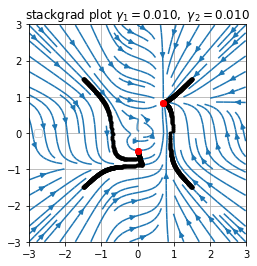

W0503 12:50:15.413100 140735505957760 legend.py:1289] No handles with labels found to put in legend.


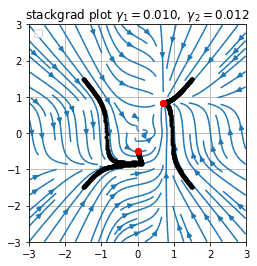

W0503 12:50:18.558583 140735505957760 legend.py:1289] No handles with labels found to put in legend.


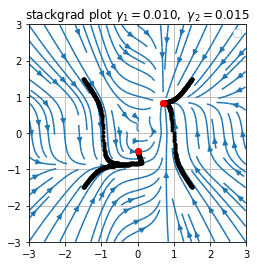

W0503 12:50:21.582138 140735505957760 legend.py:1289] No handles with labels found to put in legend.


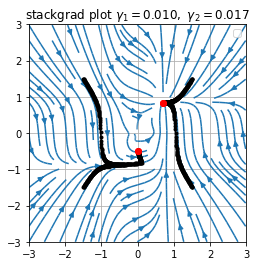

W0503 12:50:24.427752 140735505957760 legend.py:1289] No handles with labels found to put in legend.


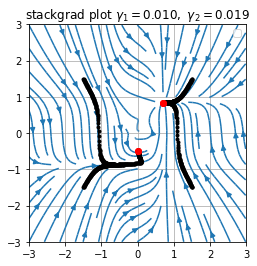

W0503 12:50:27.271014 140735505957760 legend.py:1289] No handles with labels found to put in legend.


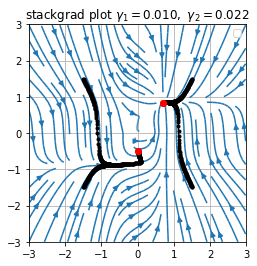

W0503 12:50:30.172117 140735505957760 legend.py:1289] No handles with labels found to put in legend.


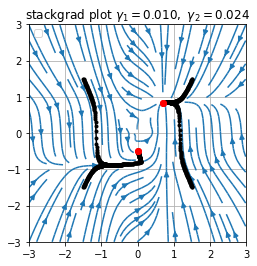

W0503 12:50:33.299119 140735505957760 legend.py:1289] No handles with labels found to put in legend.


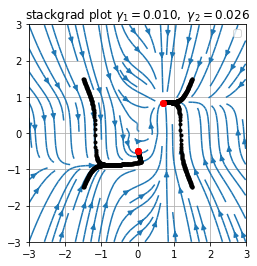

W0503 12:50:36.173906 140735505957760 legend.py:1289] No handles with labels found to put in legend.


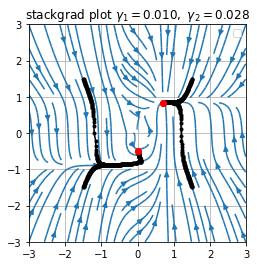

W0503 12:50:39.039757 140735505957760 legend.py:1289] No handles with labels found to put in legend.


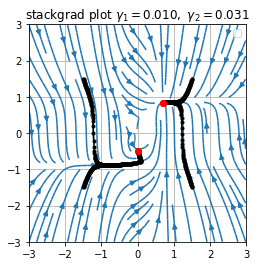

W0503 12:50:41.901010 140735505957760 legend.py:1289] No handles with labels found to put in legend.


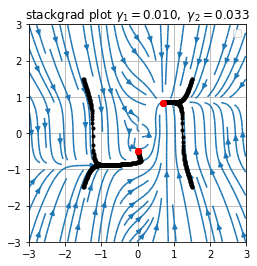

W0503 12:50:44.764188 140735505957760 legend.py:1289] No handles with labels found to put in legend.


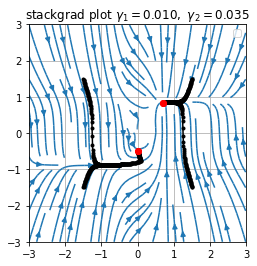

W0503 12:50:47.762907 140735505957760 legend.py:1289] No handles with labels found to put in legend.


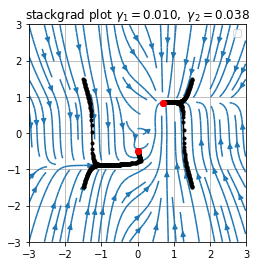

W0503 12:50:50.608742 140735505957760 legend.py:1289] No handles with labels found to put in legend.


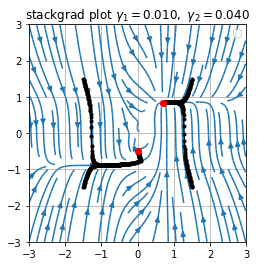

W0503 12:50:53.565742 140735505957760 legend.py:1289] No handles with labels found to put in legend.


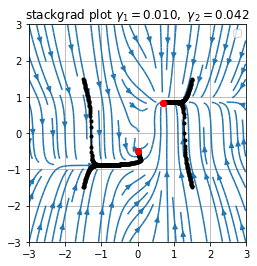

W0503 12:50:56.426852 140735505957760 legend.py:1289] No handles with labels found to put in legend.


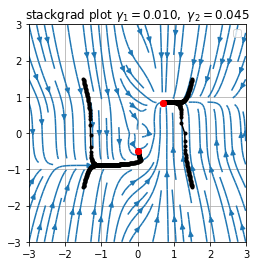

W0503 12:50:59.302078 140735505957760 legend.py:1289] No handles with labels found to put in legend.


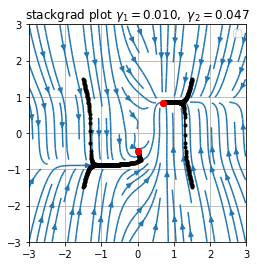

W0503 12:51:02.374990 140735505957760 legend.py:1289] No handles with labels found to put in legend.


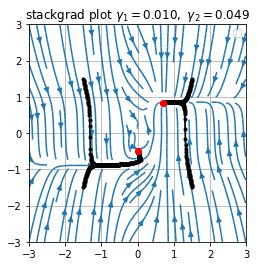

W0503 12:51:05.268022 140735505957760 legend.py:1289] No handles with labels found to put in legend.


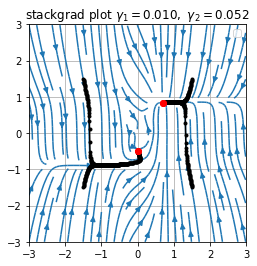

W0503 12:51:08.209532 140735505957760 legend.py:1289] No handles with labels found to put in legend.


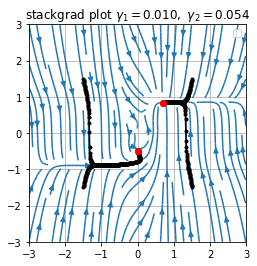

W0503 12:51:11.045607 140735505957760 legend.py:1289] No handles with labels found to put in legend.


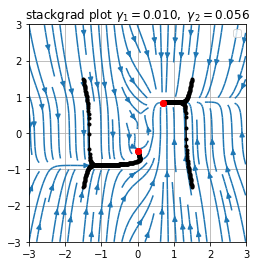

W0503 12:51:13.977315 140735505957760 legend.py:1289] No handles with labels found to put in legend.


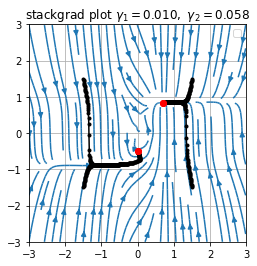

W0503 12:51:16.800357 140735505957760 legend.py:1289] No handles with labels found to put in legend.


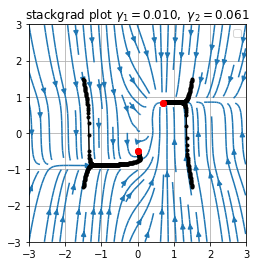

W0503 12:51:19.831543 140735505957760 legend.py:1289] No handles with labels found to put in legend.


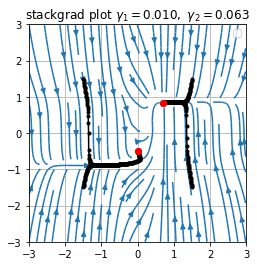

W0503 12:51:22.758038 140735505957760 legend.py:1289] No handles with labels found to put in legend.


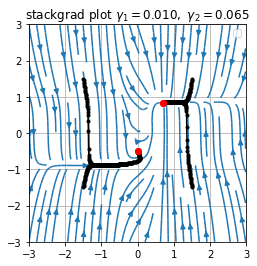

W0503 12:51:25.615943 140735505957760 legend.py:1289] No handles with labels found to put in legend.


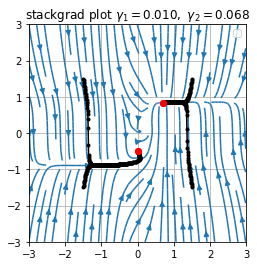

W0503 12:51:28.535207 140735505957760 legend.py:1289] No handles with labels found to put in legend.


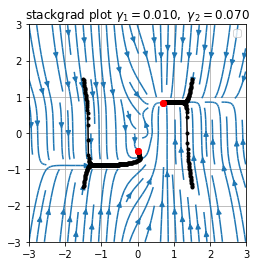

W0503 12:51:31.388526 140735505957760 legend.py:1289] No handles with labels found to put in legend.


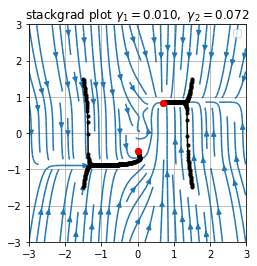

W0503 12:51:34.262016 140735505957760 legend.py:1289] No handles with labels found to put in legend.


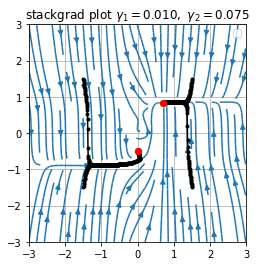

W0503 12:51:37.255096 140735505957760 legend.py:1289] No handles with labels found to put in legend.


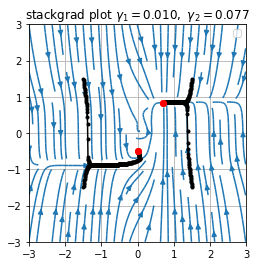

W0503 12:51:40.199775 140735505957760 legend.py:1289] No handles with labels found to put in legend.


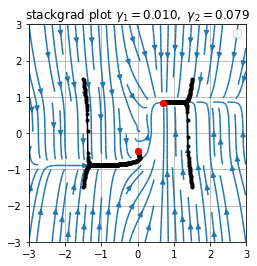

W0503 12:51:43.111155 140735505957760 legend.py:1289] No handles with labels found to put in legend.


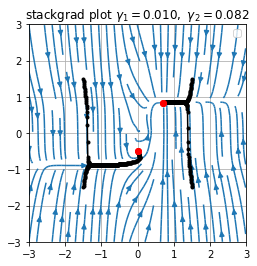

W0503 12:51:46.106389 140735505957760 legend.py:1289] No handles with labels found to put in legend.


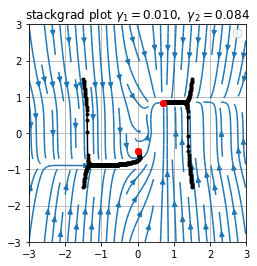

W0503 12:51:48.998004 140735505957760 legend.py:1289] No handles with labels found to put in legend.


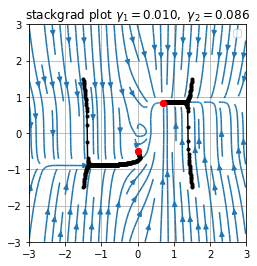

W0503 12:51:51.889991 140735505957760 legend.py:1289] No handles with labels found to put in legend.


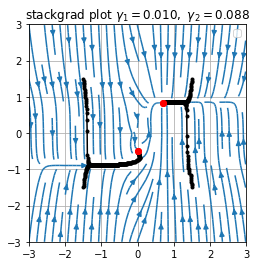

W0503 12:51:54.875159 140735505957760 legend.py:1289] No handles with labels found to put in legend.


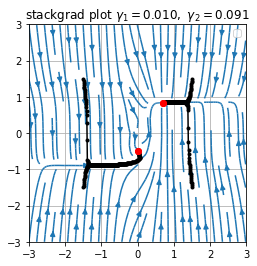

W0503 12:51:57.914845 140735505957760 legend.py:1289] No handles with labels found to put in legend.


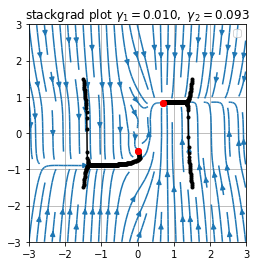

W0503 12:52:00.858764 140735505957760 legend.py:1289] No handles with labels found to put in legend.


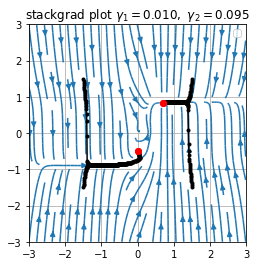

W0503 12:52:03.794548 140735505957760 legend.py:1289] No handles with labels found to put in legend.


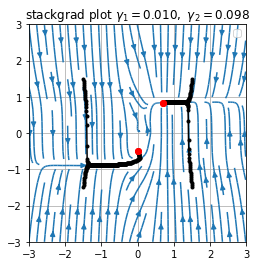

W0503 12:52:06.768762 140735505957760 legend.py:1289] No handles with labels found to put in legend.


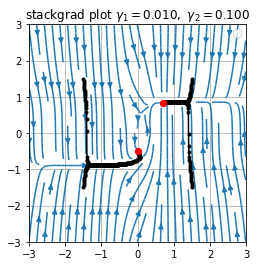

In [7]:
""" Game Configurations """
key = random.PRNGKey(0)
config_grid = dict(xlim=[-3,3], ylim=[-3,3])
config_sampling = dict(sampling_mode='grid', N=2**2)
config_stream = dict(N=32)

""" Run settings """
num_iter = 1e4
gamma = 1e-2
order = 1
n_frames = 40

updates = [simgrad, stackgrad]
update_names = ["simgrad", "stackgrad"]

updates = [stackgrad]
update_names = ["stackgrad"]


""" Prelimiaries """
ratios = np.vstack([np.linspace(1,10**-order, n_frames),
                   np.linspace(1,10**order, n_frames)]).T

ratios = np.vstack([np.linspace(1,1,n_frames),
                   np.linspace(1,10,n_frames)]).T


""" Run """
for update, update_name in zip(updates, update_names):
    for i,ratio in enumerate(ratios):
        gamma1, gamma2 = ratio*gamma
    
        Gamma = np.array([gamma1, gamma2])
        update_timescale = lambda *x: Gamma*update(*x)
    
        fig, ax = plt.subplots(nrows=1, ncols=1)
    
        """ Plot graident descent """
        grid = initial_grid(key, **config_grid, **config_sampling)
        x = vmap(partial(scan, update_timescale), (0, None))(grid, num_iter)
        plot_trajectories(ax, x, **config_grid)
        ax.set_title('Discrete time update')
    
        plot_stream(ax, update_timescale, **config_grid, **config_stream)
        ax.set_title(r'{} plot $\gamma_1={:.3f},\ \gamma_2={:.3f}$'.format(update_name, *Gamma))
    
        ax.legend()
        plt.savefig("figs/{}_gif_{:05d}.png".format(update_name, i))
        plt.show()

In [5]:
!convert -delay 40 -loop 0 figs/stackgrad_gif_*.png figs/stackgrad.gif